<a href="https://colab.research.google.com/github/NucleiDatorum/Portfolio/blob/main/outflow_from_fitness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=+2><b>Сратегия удержания клиентов в сети фитнес-центров</b></font><br>

**Описание проекта:**<br>
Сеть фитнес-центров «Культурист-датасаентист» столкнулась с довольно распространённой проблемой - отток клиентов.<br>
По какой-то причине некоторые клиенты, походив определённое время в спортзал, уходят и больше не возвращаются.<br>
Отдел по работе с клиентами перевёл в электронный вид множество анкет пользователей.<br>
Данные сохранены в csv-файле и содержат сведения за месяц до оттока и факт самого оттока.<br>

**Задача:**<br>
провести анализ и подготовить план действий по удержанию клиентов.

**Краткое содержание:**
- загрузим и исследуем данные;
- построим модель прогнозирования оттока пользователей;
- проведём кластеризацию и сформируем типичные портреты пользователей;
- выделим основные признаки, наиболее сильно влияющие на отток;
- сформулируем выводы;
- предложим рекомендации для снижения оттока.

# Шаг 1. Знакомство с данными

На этом шаге:
- загрузим предоставленные данные;
- оценим их объём и качество;
- изучим признаки и их тип (числовые или категориальные).

In [1]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# прочитаем файл, сохраним его в переменную и выведем первые строки
df = pd.read_csv('/content/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# нормализуем названия столбцов и выведем общую информацию о таблице
df.columns = map(str.lower, df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Описание данных:
- `gender` — пол
- `near_location` — проживание или работа в районе, где находится фитнес-центр
- `partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `group_visits` — факт посещения групповых занятий
- `phone` — наличие контактного телефона
- `age` — возраст
- `avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
- `month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
- `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `churn` — факт оттока в текущем месяце.

In [4]:
dup = df.duplicated().sum()
f'Количество дубликатов = {dup}'

'Количество дубликатов = 0'

## Вывод 1

Таблица содержит 4 тысячи наблюдений по 14 признакам. Пропусков нет. Дубликатов нет.<br>
7 признаков являются бинарными или dummy-переменными, принимающими значения 0 и 1: пол, близость проживания, партнерство, промо-код от знакомого, наличие контактного телефона, групповое посещение или нет, факт оттока в текущем месяце. <br>
Признак по типу абонемента содержит 4 категории - месяц, 3 месяца, 6 месяцев, год.<br>
Остальные признаки - числовые: возраст, суммарная выручка, срок до окончания абонемента, лайфтайм, средняя частота посещений в неделю за всё время и за предыдущий месяц.

# Шаг 2. Исследовательский анализ данных

На этом шаге:
- изучим общую статистику;
- посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- построим столбчатые гистограммы и распределения признаков для двух групп - ушедших и оставшихся;
- построим матрицу корреляций.

## 2.1. Общая статистика

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<div style="border:solid LawnGreen 2px; padding: 40px">

Мужчин и женщин в выборке примерно поровну.<br>
Проживающих или работающих рядом с фитнес-центром больше, чем тех, кто живёт или работает далеко.<br>
Посетителей по промо-коду от работодателя или от знакомого чуть меньше, чем остальных.<br>
Контактный номер телефона известен для большинства клиентов.<br>
Средний возраст - около 30 лет.<br>
Средний лайфтайм - 3.7 месяца.<br>
Средняя частота посещений в неделю - 2.<br>
Оставшихся примерно в 4 раза больше, чем ушедших в отток.

## 2.2. Статистика по группам

In [6]:
# посмотрим на средние значения признаков
# для оставшихся(0) и для тех, кто ушел(1)
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


<div style="border:solid LawnGreen 2px; padding: 40px">

В группе оттока количество клиентов с промокодом от друга или работодателя меньше,<br>
так же в этой группе меньше средний срок абонемента, факт группового посещения,
чуть меньше средний возраст, меньше суммарная выручка,
заметно меньше среднее срока до окончания абонемента,
средний лайфтайм и частота посещений в неделю.

## 2.3. Распределение признаков по группам

In [7]:
# разделим выборку на две части: на оставшихся и ушедших в отток
churn_0 = df.query('churn == 0')
churn_1 = df.query('churn == 1')

### Функции

In [8]:
def stat(x_0, x_1):
    """Функция для вывода общей статистики по столбцу.

    На вход принимает признак из среза с оставшимися клиентами
    и тот же признак из среза с отточными клиентами.
    """
    pass
    d_0 = (x_0
           .describe()
           .reset_index()
           .rename(columns={'index': 'показатель',
                            'churn': 'оставшиеся'}))

    d_1 = (x_1
           .describe()
           .reset_index()
           .rename(columns={'index': 'показатель',
                            'churn': 'отток'}))

    d = pd.merge(d_0,
                 d_1,
                 left_on='показатель',
                 right_on='показатель')

    display(d)

In [9]:
def frequency(x_0, x_1, title):
    """Функция для построения графика частоты встречаемости признака по группам.

    На вход принимает признак из срезов с оставшимися и отточными клиентами
    и название графика.
    """
    pass
    plt.subplots(figsize = (10,5))

    sns.countplot(x=x_0,
                  color='LawnGreen',
                  label='остались')

    sns.countplot(x=x_1,
                  color='Green',
                  label='ушли в отток')

    plt.title(title)
    plt.legend();

In [10]:
def distribution(x_0, x_1, bins, title):
    """Функция для построения графика распределения признака по группам.

    На вход принимает признак из срезов с оставшимися и отточными клиентами,
    число корзин и название графика.
    """
    pass
    range_0 = x_0.max() - x_0.min()
    range_1 = x_1.max() - x_1.min()

    plt.subplots(figsize = (10,5))

    plt.hist(x_0,
             color = 'LawnGreen',
             label='остались',
             bins = int(range_0/bins))

    plt.hist(x_1,
             color = 'Green',
             label='ушли в отток',
             bins = int(range_1/bins))

    plt.xlabel('Значение признака')
    plt.ylabel('Количество наблюдений')
    plt.title(title)
    plt.legend();

### 2.3.1. Возраст клиентов

In [11]:
# общая статистика для возраста по группам
stat(churn_0.age,
     churn_1.age)

,показатель,age_x,age_y
0,count,2939.000000,1061.000000
1,mean,29.976523,26.989632
2,std,3.009933,2.895163
3,min,19.000000,18.000000
4,25%,28.000000,25.000000
5,50%,30.000000,27.000000
6,75%,32.000000,29.000000
7,max,41.000000,38.000000


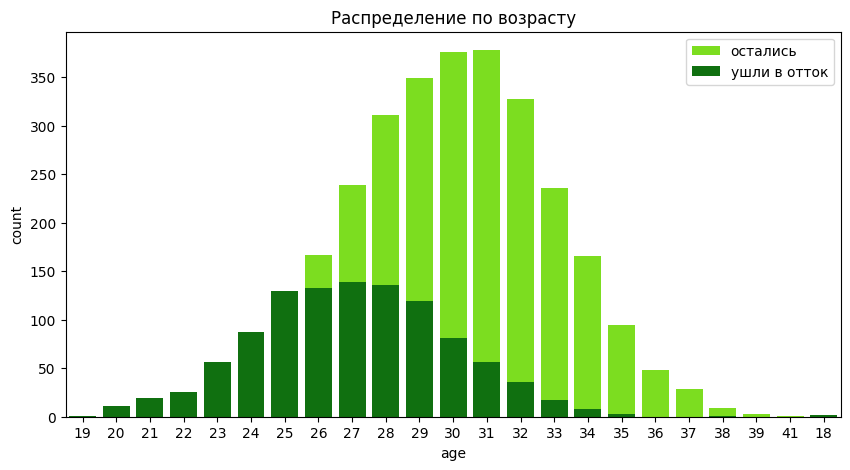

In [12]:
# график частоты встречаемости каждого возраста по группам
frequency(churn_0['age'],
          churn_1['age'],
          'Распределение по возрасту')

<div style="border:solid LawnGreen 2px; padding: 40px">

Гистограмма возраста имеет форму нормального распределения для обеих групп, но пики приходятся на разные значения:
- для оставшихся - 29-30 лет;
- для ушедших - 27 лет.

### 2.3.2. Тип абонемента

In [13]:
# общая статистика для типов абонемента по группам
stat(churn_0.contract_period,
     churn_1.contract_period)

,показатель,contract_period_x,contract_period_y
0,count,2939.000000,1061.000000
1,mean,5.747193,1.728558
2,std,4.716942,2.132371
3,min,1.000000,1.000000
4,25%,1.000000,1.000000
5,50%,6.000000,1.000000
6,75%,12.000000,1.000000
7,max,12.000000,12.000000


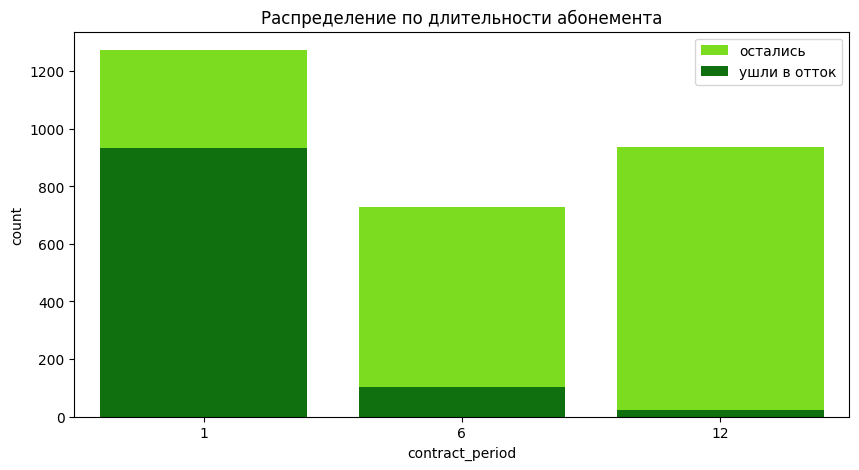

In [14]:
# график частоты встречаемости
# типа абонемента для каждой группы
frequency(churn_0['contract_period'],
          churn_1['contract_period'],
          'Распределение по длительности абонемента')

<div style="border:solid LawnGreen 2px; padding: 40px">

Для группы оставшихся видим два пиковых значения - 1 месяц и год.<br>
Большинство ушедших имели абонемент на 1 месяц.

### 2.3.3. Срок до окончания абонемента

In [15]:
# общая статистика
# для срока до окончания абонемента по группам
stat(churn_0.month_to_end_contract,
     churn_1.month_to_end_contract)

,показатель,month_to_end_contract_x,month_to_end_contract_y
0,count,2939.000000,1061.000000
1,mean,5.283089,1.662582
2,std,4.363522,1.964593
3,min,1.000000,1.000000
4,25%,1.000000,1.000000
5,50%,6.000000,1.000000
6,75%,10.000000,1.000000
7,max,12.000000,12.000000


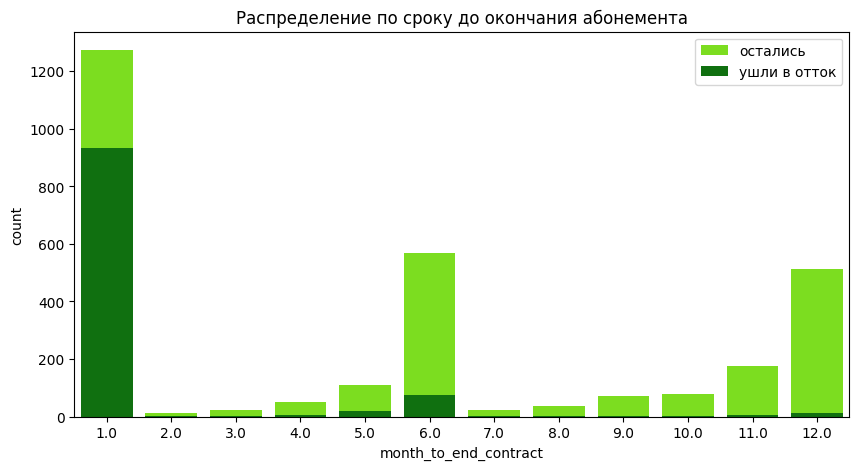

In [16]:
# график частоты встречаемости
# сроков до окончания абонемента для каждой группы
frequency(churn_0['month_to_end_contract'],
          churn_1['month_to_end_contract'],
          'Распределение по сроку до окончания абонемента')

<div style="border:solid LawnGreen 2px; padding: 40px">

Распределение по этому признаку повторяет картину распределения по типу абонемента и связано с ним логически.

### 2.3.4. Lifetime

In [17]:
# общая статистика для liftime по группам
stat(churn_0.lifetime,
     churn_1.lifetime)

,показатель,lifetime_x,lifetime_y
0,count,2939.000000,1061.000000
1,mean,4.711807,0.990575
2,std,3.874780,1.110799
3,min,0.000000,0.000000
4,25%,2.000000,0.000000
5,50%,4.000000,1.000000
6,75%,6.000000,1.000000
7,max,31.000000,9.000000


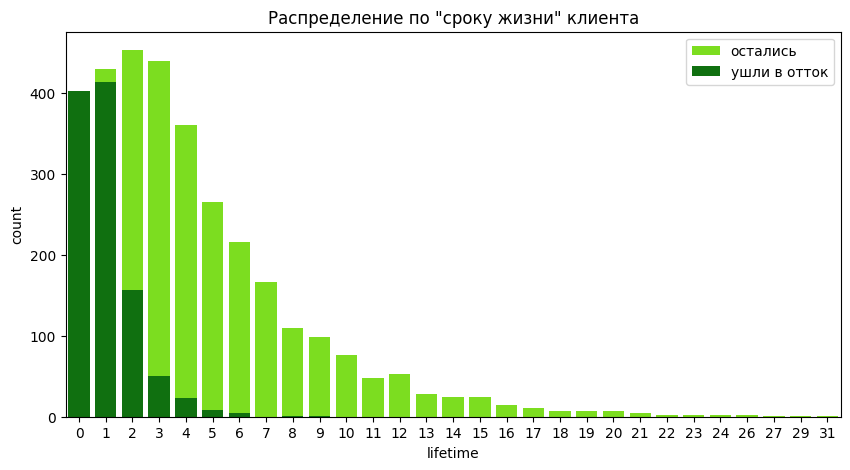

In [18]:
# график частоты встречаемости
# "срока жизни" клиента для каждой группы
frequency(churn_0['lifetime'],
          churn_1['lifetime'],
          'Распределение по "сроку жизни" клиента')

<div style="border:solid LawnGreen 2px; padding: 40px">

"Срок жизни" клиентов для группы оставшихся распределён нормально, с небольшой ассиметрией вправо и пиком 2 месяца.<br>
В группе ушедших преобладают клиенты со "сроком жизни" 1 и менее месяца.<br>
Максимальный "лайфтайм" для оттока - 9 месяцев, для оставшихся - 2 года 7 месяцев.

### 2.3.5. Средняя выручка

In [19]:
# общая статистика для средней выручки по группам
stat(churn_0.avg_additional_charges_total,
     churn_1.avg_additional_charges_total)

,показатель,avg_additional_charges_total_x,avg_additional_charges_total_y
0,count,2939.000000,1061.000000
1,mean,158.445715,115.082899
2,std,99.801599,77.696419
3,min,0.171862,0.148205
4,25%,76.920993,50.629127
5,50%,149.881171,103.814686
6,75%,224.448274,165.616858
7,max,552.590740,425.535220


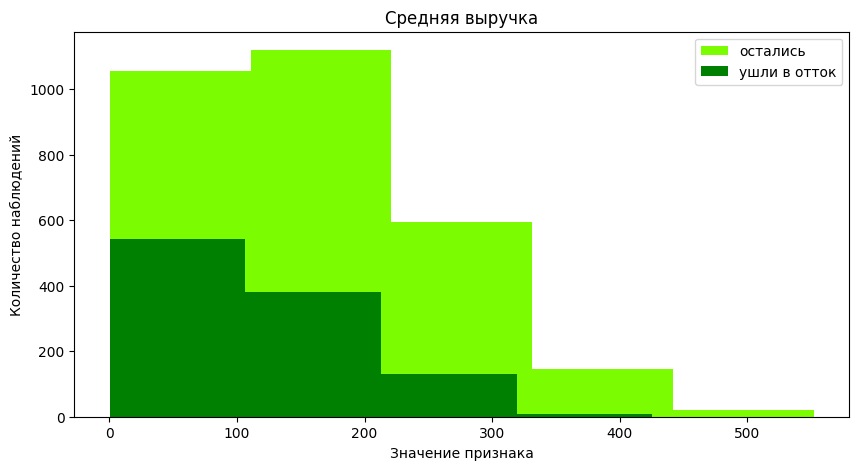

In [20]:
# график распределения для средней выручки по группам
distribution(churn_0['avg_additional_charges_total'],
             churn_1['avg_additional_charges_total'],
             100,
             'Средняя выручка')

<div style="border:solid LawnGreen 2px; padding: 40px">

Форма распределения для обеих групп похожа - нормальное с ассиметрией вправо.<br>
В целом, клиенты из группы оттока тратили на фитес денег меньше, чем из группы оставшихся.

### 2.3.6. Средняя частота посещений в неделю

In [21]:
# общая статистика для частоты посещений по группам
stat(churn_0.avg_class_frequency_total,
     churn_1.avg_class_frequency_total)

,показатель,avg_class_frequency_total_x,avg_class_frequency_total_y
0,count,2939.000000,1061.000000
1,mean,2.024876,1.474995
2,std,1.016006,0.694705
3,min,0.000000,0.000000
4,25%,1.283137,1.010771
5,50%,2.043252,1.491187
6,75%,2.732944,1.956438
7,max,6.023668,3.478646


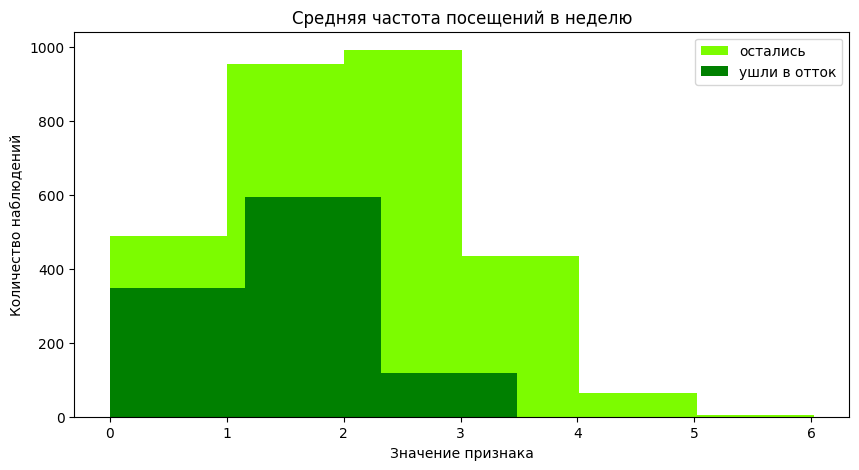

In [22]:
# график распределения
# для средней частоты посещений в неделю по группам
distribution(churn_0['avg_class_frequency_total'],
             churn_1['avg_class_frequency_total'],
             1,
             'Средняя частота посещений в неделю')

<div style="border:solid LawnGreen 2px; padding: 40px">

Форма распределения для обеих групп похожа, но пики имеют немного разные значения: для оставшихся - это 2-3 посещения в неделю, а для ушедших - 1-2 посещения.

### 2.3.7. Частота посещений за месяц, предшествующий оттоку

In [23]:
# общая статистика для частоты посещений
# в предшествующий оттоку месяц по группам
stat(churn_0.avg_class_frequency_current_month,
     churn_1.avg_class_frequency_current_month)

,показатель,avg_class_frequency_current_month_x,avg_class_frequency_current_month_y
0,count,2939.000000,1061.000000
1,mean,2.027882,1.044546
2,std,1.018994,0.770237
3,min,0.000000,0.000000
4,25%,1.297021,0.421337
5,50%,2.046697,0.979445
6,75%,2.740648,1.588576
7,max,6.146783,3.540271


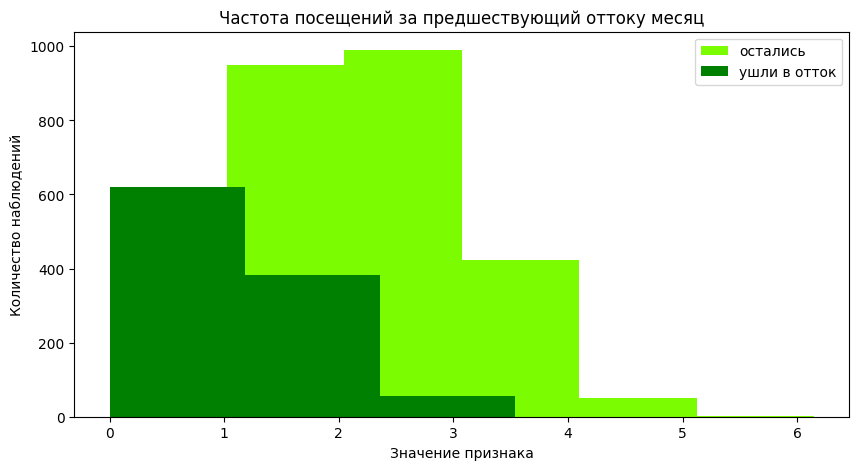

In [24]:
# график частоты посещений за предшествующий оттоку месяц по группам
distribution(churn_0['avg_class_frequency_current_month'],
             churn_1['avg_class_frequency_current_month'],
             1,
             'Частота посещений за предшествующий оттоку месяц')

<div style="border:solid LawnGreen 2px; padding: 40px">

Распределение для группы оставшихся осталось прежним. <br>
А для группы из оттока пик сместился в сторону еденицы.

## 2.3.8. Матрица корреляций

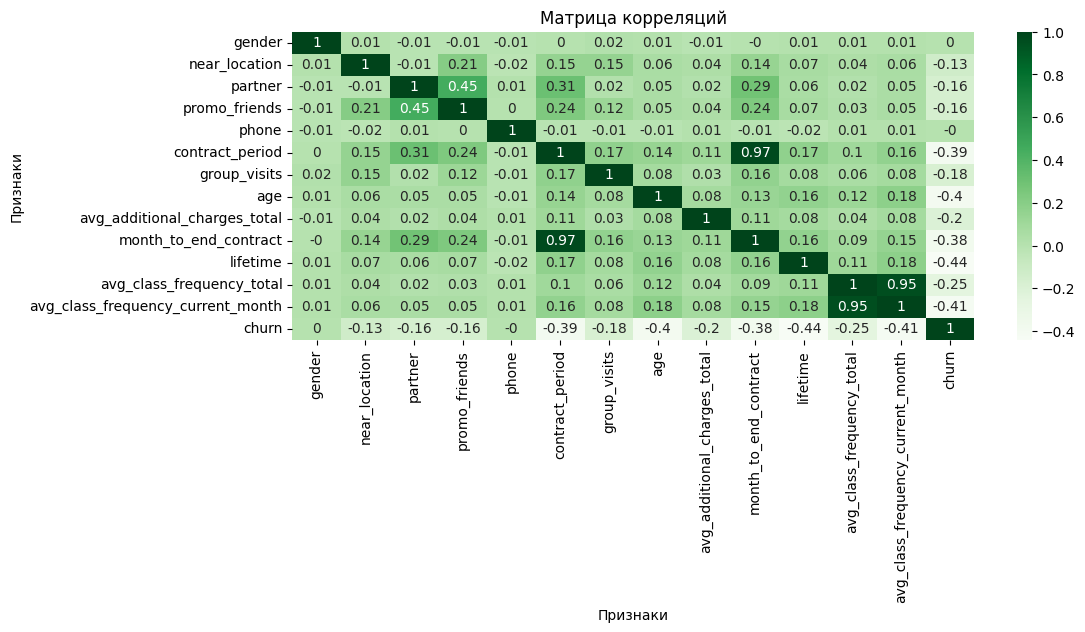

In [25]:
# построим матрицу корреляций
cm = df.corr().round(2)
fig, ax = plt.subplots(figsize=(11, 4))
sns.heatmap(cm, cmap="Greens", annot=True)
plt.title('Матрица корреляций')
plt.xlabel('Признаки')
plt.ylabel('Признаки');

<div style="border:solid LawnGreen 2px; padding: 40px">

Факт оттока не коррелирует ни с одним из признаков.<br>
Очень сильная взаимная корреляция есть между средней частотой посещаемости за всё время и за последний месяц,<br>
а также между типом абонемента и сроком до окончания абонемента.<br>
Помня о том, что взаимная корреляция негативно влияет на линейные модели, удалим из каждой пары по одному столбцу: month_to_end_contract и avg_class_frequency_total.

In [26]:
# удалим коррелирующие столбцы
df = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

## Вывод 2

Каких_то ярких выбросов и перекосов в данных не наблюдается.<br>
Между двумя парами признаков есть взаимная корреляция:
- частота посещений за всё время и за последний месяц;
- тип абонемента и срок до окончания абонемента.<br><br>
Удалили по одному признаку из каждой пары:
- срок до окончания абонемента,
- средняя частота посещений в неделю за всё время.<br><br>
Целевая переменная "churn" не коррелирует ни с одним из признаков.<br>
На этих данных можно строить модель бинарной классификации пользователей.

# Шаг 3. Модель прогнозирования оттока пользователей

На этом шаге:
- разделим данные на обучающую и тестовую выборки;
- обучим модель двумя способами: логистической регрессией и случайным лесом;
- оценим метрики accuracy, precision и recall;
- выберем лучшую модель.

In [27]:
# разделим данные на признаки (матрица X) и целевую переменную (y),
# где целевая переменная - это факт оттока пользователя (churn)
X = df.drop('churn', axis = 1)
y = df['churn']

In [28]:
# разделим данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [30]:
# зададим список моделей
models = [LogisticRegression(), RandomForestRegressor()]

In [31]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display(
        'ACC:{:.2f} PREC:{:.2f} REC:{:.2f} '.format(
            accuracy_score(y_test, y_pred.round()),
            precision_score(y_test, y_pred.round()),
            recall_score(y_test, y_pred.round())
        )
    )

In [32]:
# выведем метрики
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test
    )

LogisticRegression()


'ACC:0.90 PREC:0.79 REC:0.82 '

RandomForestRegressor()


'ACC:0.89 PREC:0.80 REC:0.77 '

<div style="border:solid LawnGreen 2px; padding: 40px">

Обе модели показали хорошие результаты.<br>
**Accuracy** чуть больше у логистической регрессии. Но стоит учесть, что эта метрика может быть обманчивой в случае с несбалансированными данными, когда один класс преобладает над другим. В нашем случае число ушедших в отток клиентов значительно меньше оставшихся.<br>
**Precision** отражает, насколько надежна модель при предсказании ответов, где churn=1, т.е. насколько точно угадывает факт оттока. И эта метрика лучше у модели случайного леса.<br>
На основании этого выберем модель RandomForestRegressor().

In [33]:
# обучим финальную модель
final_model = RandomForestRegressor()
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

In [34]:
# выведем признаки в порядке убывания важности
feature_weights = pd.DataFrame(
    data={
        'feature': X.columns,
        'impotance': final_model.feature_importances_
    }
)
feature_weights.sort_values(by='impotance', ascending=False)

,feature,impotance
9,lifetime,0.378904
10,avg_class_frequency_current_month,0.207780
8,avg_additional_charges_total,0.123509
5,contract_period,0.118937
7,age,0.105671
6,group_visits,0.013704
3,promo_friends,0.012750
0,gender,0.012147
2,partner,0.010052
1,near_location,0.009956


## Вывод 3

Мы обучили модель двумя способами: методом логистической регрессии и случайным лесом.<br>
Случайный лес показал лучшие результаты по метрике precision(точность).<br>
Далее мы повторно обучили модель методом случайного леса и получили признаки с наибольшим весом.<br>
Самый большой вес показал "срок жизни" клиента.<br>
На втором месте - частота посещений в неделю за месяц до оттока.<br>
Далее можно выделить суммарную выручку, срок абонемента и возраст.<br>
Все остальные признаки заметно слабее и очень слабо влияют на отток.

# Шаг 4. Кластеризация пользователей

**На этом шаге:**
- построим матрицу расстояний;
- нарисуем дендрограмму;
- обучим модель алгоритмом K-Means;
- построим распределения признаков для кластеров;
- для каждого кластера посчитаем долю оттока.

## 4.1. Матрица расстояний и дендрограмма

In [35]:
# cтандартизируем данные
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

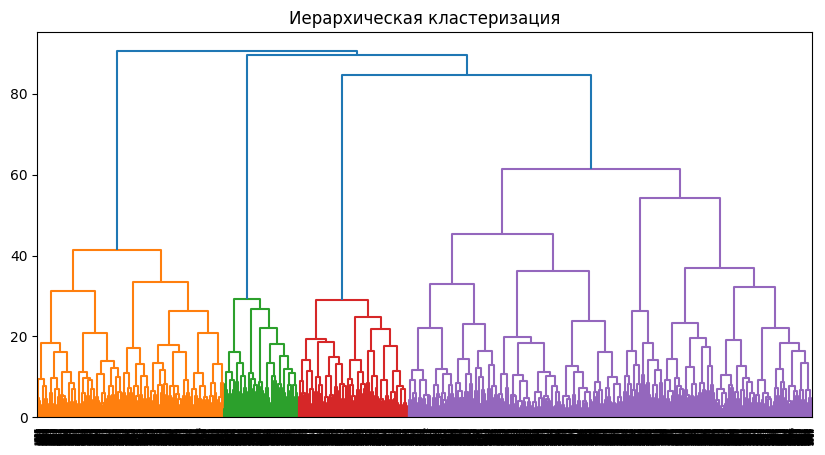

In [36]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')

# дендрограмма
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show();

<div style="border:solid LawnGreen 2px; padding: 40px">

Оптимальное число кластеров - 5.

## 4.2. Алгоритм K-Means

In [37]:
# зададим модель K-Means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)

# спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраним метки кластера в поле нашего датасета
df['cluster_km'] = labels

# Переименуем названия кластеров
df.loc[df['cluster_km']==0, 'cluster_km'] = 'cluster_1'
df.loc[df['cluster_km']==1, 'cluster_km'] = 'cluster_2'
df.loc[df['cluster_km']==2, 'cluster_km'] = 'cluster_3'
df.loc[df['cluster_km']==3, 'cluster_km'] = 'cluster_4'
df.loc[df['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# выведем статистику по средним значениям признаков по кластеру
display(df.groupby('cluster_km').mean().T)

cluster_km,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.500000,0.542497,0.495050,0.496976,0.523316
near_location,0.000000,0.995803,1.000000,0.995968,0.862694
partner,0.489247,0.405037,0.201620,0.889113,0.471503
promo_friends,0.078853,0.007345,0.065707,1.000000,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,2.994624,6.505771,1.965797,6.881048,4.777202
group_visits,0.232975,0.517314,0.306931,0.524194,0.427461
age,28.679211,30.688353,27.746175,29.589718,29.297927
avg_additional_charges_total,137.125763,176.123462,122.268699,153.133261,144.208179
lifetime,2.974910,5.503673,1.973897,4.314516,3.940415


<div style="border:solid LawnGreen 2px; padding: 40px">

Как видим, наименьшее среднее по признаку оттока у четвёртого кластера. Наибольшее - у третьего.<br>
Третий кластер имеет наименьшее среднее по признаку lifetime и частоте посещения в неделю.<br>
А четвёртый, напротив - по lifetime и частоте посещения наибольшие показатели.

In [38]:
# посмотрим на количество оставшихся и ушедших в каждом кластере
df.groupby('churn')['cluster_km'].value_counts()

churn  cluster_km
0      cluster_2     942
       cluster_4     871
       cluster_3     510
       cluster_1     333
       cluster_5     283
1      cluster_3     601
       cluster_1     225
       cluster_4     121
       cluster_5     103
       cluster_2      11
Name: count, dtype: int64

<div style="border:solid LawnGreen 2px; padding: 40px">

Видим подтверждение предыдущего наблюдения - больше всего ушедших в третьем кластере, меньше всего - в четвёртом.<br>
Посмотрим на распределение значимых признаков в этих кластерах.

## 4.3. Анализ распределения  признаков по кластерам

In [39]:
# сохраним два среза - 3 и 4 кластер
kl_3 = df.query('cluster_km == "cluster_3"')
kl_4 = df.query('cluster_km == "cluster_4"')

### Функции

In [40]:
def stat_kl(x_3, x_4):
    """Функция для вывода общей статистики по кластерам.

    На вход принимает признак из кластера 3
    и тот же признак из кластера 4.
    """
    pass
    d_3 = (x_3
           .describe()
           .reset_index()
           .rename(columns={'index': 'показатель',
                            'cluster_3': 'кластер_3'}))

    d_4 = (x_4
           .describe()
           .reset_index()
           .rename(columns={'index': 'показатель',
                            'cluster_4': 'кластер_4'}))

    d = pd.merge(d_3,
                 d_4,
                 left_on='показатель',
                 right_on='показатель')

    display(d)

In [41]:
def frequency(x_3, x_4, title):
    """Функция для построения графика частоты встречаемости признака по кластерам.

    На вход принимает признак из кластеров 3 и 4
    и название графика.
    """
    pass
    sns.kdeplot(x_3,
                shade=True,
                label='кластер 3')

    sns.kdeplot(x_4,
                shade=True,
                label='кластер 4')

    plt.title(title)
    plt.legend();

### 4.3.1. Lifetime

In [42]:
# общая статистика по liftame для кластеров
stat_kl(kl_3.lifetime,
        kl_4.lifetime)

,показатель,lifetime_x,lifetime_y
0,count,1111.000000,992.000000
1,mean,1.973897,4.314516
2,std,2.105814,3.769583
3,min,0.000000,0.000000
4,25%,1.000000,1.000000
5,50%,1.000000,3.000000
6,75%,3.000000,6.000000
7,max,16.000000,24.000000


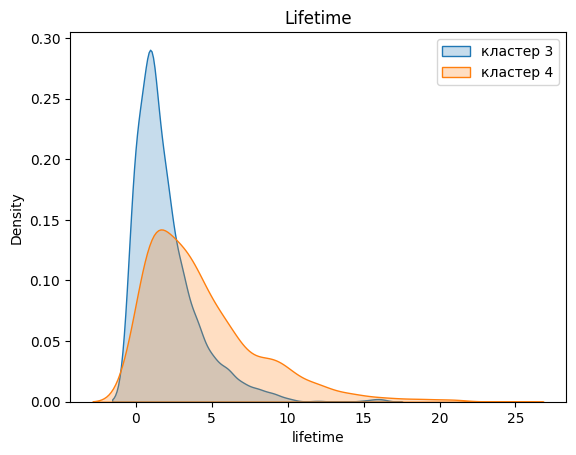

In [43]:
# график плотности "срока жизни" клиента для кластеров
frequency(kl_3.lifetime,
          kl_4.lifetime,
          'Lifetime')

<div style="border:solid LawnGreen 2px; padding: 40px">

Чаще всего клиенты уходят уже примерно через месяц. Это значит, что с самого начала им что-то не нравится и они не хотят продолжать.

### 4.3.2. Частота посещений

In [44]:
# общая статистика по средней частоте посещений в неделю за месяц до оттока
stat_kl(kl_3.avg_class_frequency_current_month,
        kl_4.avg_class_frequency_current_month)

,показатель,avg_class_frequency_current_month_x,avg_class_frequency_current_month_y
0,count,1111.000000,992.000000
1,mean,1.228960,1.915498
2,std,0.848303,1.041208
3,min,0.000000,0.000000
4,25%,0.560570,1.120233
5,50%,1.153160,1.897887
6,75%,1.797083,2.645280
7,max,3.855104,6.146783


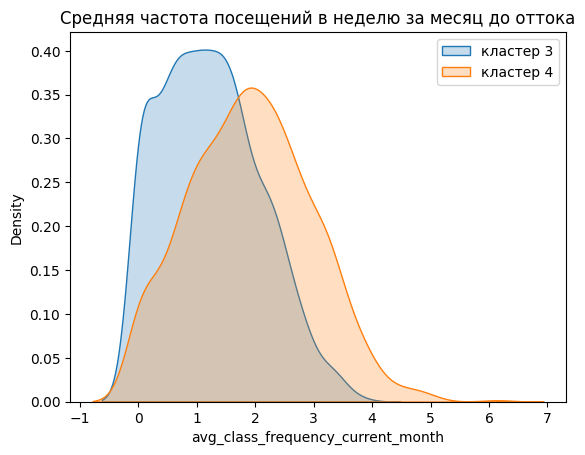

In [45]:
# график плотности частоты посещений в неделю
frequency(
    kl_3.avg_class_frequency_current_month,
    kl_4.avg_class_frequency_current_month,
    'Средняя частота посещений в неделю за месяц до оттока'
)

<div style="border:solid LawnGreen 2px; padding: 40px">

Пик плотности по частоте посещений для группы оттока приходится на 1, <br>
а для группы оставшихся - на 3. <br>
Чем чаще клиент ходит в клуб, тем меньше у него желания уйти навсегда.

### 4.3.3. Суммарная выручка

In [46]:
# общая статистика по средней суммарной выручке
stat_kl(kl_3.avg_additional_charges_total,
        kl_4.avg_additional_charges_total)

,показатель,avg_additional_charges_total_x,avg_additional_charges_total_y
0,count,1111.000000,992.000000
1,mean,122.268699,153.133261
2,std,83.927985,95.977083
3,min,0.171862,0.148205
4,25%,53.519768,75.039532
5,50%,109.549299,147.838282
6,75%,173.910034,220.906612
7,max,468.205360,460.904008


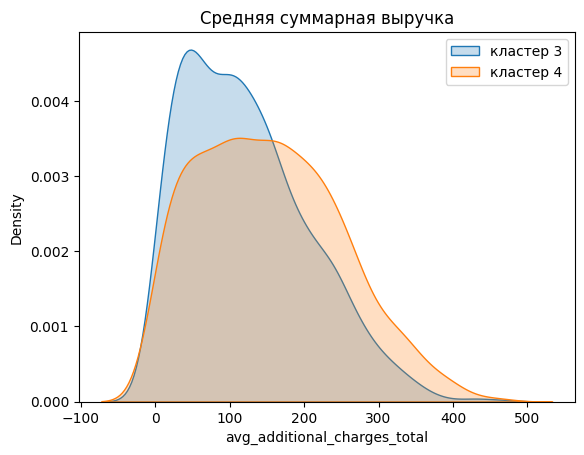

In [47]:
# график плотности суммарной выручки
frequency(
    kl_3.avg_additional_charges_total,
    kl_4.avg_additional_charges_total,
    'Средняя суммарная выручка'
)

<div style="border:solid LawnGreen 2px; padding: 40px">

На этом графике можно заметить склонность оставшихся делать покупки на чуть большие суммы.<br> Возможно, такие клиенты предпочитают более качественные и дорогие вещи, <br>
а клиенты из группы ушедших - более дешевые, которые не жалко выкинуть.

### 4.3.4. Срок абонемента

In [48]:
# общая статистика по сроку абонемента
stat_kl(kl_3.contract_period,
        kl_4.contract_period)

,показатель,contract_period_x,contract_period_y
0,count,1111.000000,992.000000
1,mean,1.965797,6.881048
2,std,2.421134,4.731325
3,min,1.000000,1.000000
4,25%,1.000000,1.000000
5,50%,1.000000,6.000000
6,75%,1.000000,12.000000
7,max,12.000000,12.000000


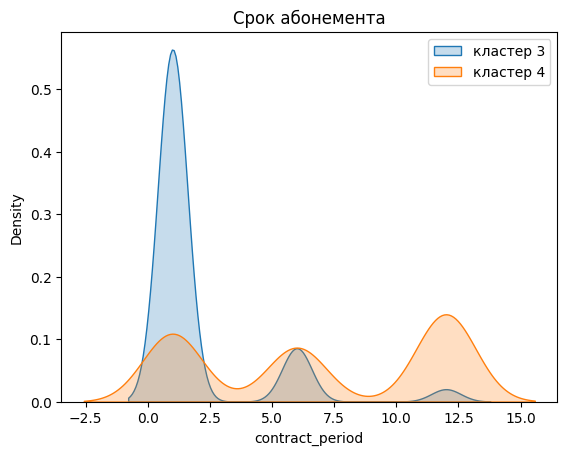

In [49]:
# график плотности по сроку абонемента
frequency(kl_3.contract_period,
          kl_4.contract_period,
          'Срок абонемента')

<div style="border:solid LawnGreen 2px; padding: 40px">

Среди клиентов, ушедших в отток, преобладает тип абонемента 1 месяц. <br>
Но есть часть клиентов, которая "бросила" фитнес с абонементом 6 месяцев и год.

### 4.3.5. Возраст

In [50]:
# общая статистика по возрасту
stat_kl(kl_3.age,
        kl_4.age)

,показатель,age_x,age_y
0,count,1111.000000,992.000000
1,mean,27.746175,29.589718
2,std,2.994051,3.103986
3,min,18.000000,20.000000
4,25%,26.000000,28.000000
5,50%,28.000000,30.000000
6,75%,30.000000,32.000000
7,max,37.000000,38.000000


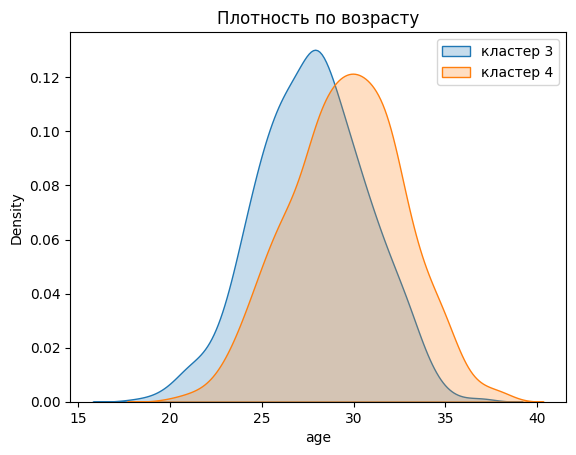

In [51]:
# график плотности по возрасту
frequency(kl_3.age,
          kl_4.age,
          'Плотность по возрасту')

<div style="border:solid LawnGreen 2px; padding: 40px">

Графики для обоих кластеров похожи, но пики смещены - ушедшие в отток в среднем немного моложе.

## 4.4. Доля оттока для каждого кластера

In [52]:
share = (df
         .groupby('cluster_km')['churn']
         .mean()
         .reset_index()
         .sort_values(by='churn', ascending=False)
         .reset_index(drop=True))
share

,cluster_km,churn
0,cluster_3,0.540954
1,cluster_1,0.403226
2,cluster_5,0.266839
3,cluster_4,0.121976
4,cluster_2,0.011542


# Шаг 5. Выводы и рекомендации по работе с клиентами

## Проделанная работа

Мы получили опрятные данные - без пропусков, дубликатов и аномалий.<br>
7 признаков из 14 являются бинарными или dummy-переменными, принимающими значения 0 и 1. Остальные признаки - числовые.<br>
Матрица корреляций выявила две пары взаимнокоррелирующих признаков. Чтобы они не оказывали негативное влияние на модель, мы удалили по одному признаку из каждой пары. Удаленные столбцы: срок до окончания абонемента и средняя частота посещений в неделю за всё время.<br>
Целевой признак churn не коррелирует с другими признаками.<br>
Далее мы разделили выборку на обучающую и валидационную в соотношении 80:20, обучили модель двумя методами: логистической регрессией и случайным лесом, сравнили метрики и выбрали лучший метод - случайный лес.<br>
От вновь обученной методом случайного леса модели получили признаки с наибольшим весом:
- lifetime,
- avg_class_frequency_current_month,
- avg_additional_charges_total,
- contract_period,
- age.<br><br>
Разделили выборку на 5 кластеров, определили кластеры с наименьшим и наибольшим процентом оттока, сравнили эти кластеры по наиболее значимым признаками.

## Выводы

1. Большинство уходящих в отток клиентов довольно быстро принимают такое решение - примерно через месяц.
Можно предположить, чем дольше клиент посещает клуб, тем меньше вероятность, что ему захочется уйти, особенно, если ему всё нравится, он уже всех знает, со всеми подружился, одним словом, привык.
2. Средняя частота посещений в неделю у лояльных клиентов больше, что также соотносится с предположением о времени: довольные клиенты, которые не хотят уходить, посещают клуб чаще.
3. Суммарная выручка наводит на предположение, что лояльные пользователи склонны тратить бОльшие суммы, возможно, на брендовые вещи. Потому что фитнес для них по какой-то причине имеет высокую значимость.
4. Среди ушедших в отток клиентов преобладает тип абонемента 1 месяц. Но есть клиенты, которые ушли с абонементом 6 месяцев и год. Что может говорить о серьёзном намерении заниматься фитнесом в начале, но что-то пошло не так и человек решает всё бросить.

## Рекомендации

1. Необходима программа по адаптации новичков. Если человек совсем "зелёный" и никогда не занимался спортом, у него может быть очень много комплексов и неуверенности по поводу того, как он вписывается в обстановку фитнес-клуба, нормально ли он выглядит, всё ли правильно делает и т.д.
2. Создание пространства, в которое хочется возвращаться. Возможно, в фитнес-клуб можно приходить не только ради тренировок, но и на спа-процедуры, массаж и т.п. Допустим, человек тренируется 2 дня в неделю и в качестве третьего дня ему предлагают массаж со скидкой.
3. Бонусы за упорство. Продержался месяц - подарок. Ещё месяц - ещё подарок.
4. Поиск идеи, способной объединить людей в "касту фитнесофилов", дающей чувство приобщенности к чему-то большему, чем просто унылая жизнь серого человечка.